In [1]:
# this version adds multiple sets of sensors and sonics
# so for each case (file) there are number_sensors * number_sensor_sets records
# A set of sensor locations and a sonic location are assigned, data for those
# locations are pulled from the files and added to the NN input tensor, then 
# the next set of sensor locations and sonic location are assigned, data are
# pulled from the files for those locations and added to the NN input, etc

# herein, the coding is general, but in the initialization, I am just using 
# 3 sensor locations and a sonic, and taking 3 sets of these. It works as
# well as for a single set of sensor locations and sonic.  

# still need to integrate with NCAR's initialization. I see that instructions
# for doing that are on their github site.

# still need to vary reference point.  Not sure I agree now with their claim
# that having a fixed reference frame is a problem. Shifting the reference 
# frame, e.g., to the sonic location won't change the absolute distances between
# sensors, sonic and source.  In these files, all the sources are in the middle,
# and that's what the NN finds.  It will be interesting to see if shuffling the
# reference point around will make any difference.

# train CNN ~ to arpa-e publication
# assign/determine number of cases, number of sensors per case, 
# list of locations to use for sensors for each case (random?, specified?)
# loop over training data files:
# from list, determine sensor cells and coords and scale, for each case j
# collect from training data files source info - coords, rate, for each case
# find Qsmin, Qsmax = min, max source leak rates over all cases
# scale leak rates Qs as Qscl=log(Qs/Qsmin)/log(Qsmax/Qsmin)
# read velocities & transform velocities (u,v,w) to (ur,utheta,w) to (speed,angle,w)
# pull out CH4 values for case.j; pull out CH4(time) for sensors.i,j
# mark time of first detect of CH4 > CH4min for each case j 
# for each sensor i,j find Cmax.i,j and time_max i,j for each case j
# Cmax = max(Cmax.i,j) = overall max concentration
# scaling. Csclmax=log(max(C,Cmin)/Cmin)/log(Cmax/Cmin)
# compute average velocity by integrating (u,v,w) back from time_max.i,j for delta.time
# delta.time ~ time for avg vel to cross domain to sensor.i,j 
# inputs: (x,y,z.sensor,Cmax,time_max).i,j
# outputs: (xsource,ysource,Qs).j
# run through NN (and try other algs); unscale
# test against subset of inputs,outputs pairs (not used for training).

In [2]:
#conda list -n myenv

In [3]:
#module load conda
#conda env create -f environment.yml
#conda activate seals

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import xarray as xr

In [6]:
from glob import glob

In [7]:
import os

In [8]:
import math

In [9]:
# convert u,v to wind speed, wind direction at a point

def polar(angle,speed,u,v,n):
    for i in range(0, n):
        speed[i]=np.sqrt(u[i]**2 + v[i]**2)
        angle[i]=math.degrees(math.atan2(v[i],u[i]))
    return angle,speed

In [10]:
# compute wind speed and direction for 2d field 

def polar2d(angle2d,speed2d,u2d,v2d,m,n):
    for i in range(0, m):
        for j in range(0, n):
            speed2d[i][j]=np.sqrt(u2d[i][j]**2 + v2d[i][j]**2)
            angle2d[i][j]=math.degrees(math.atan2(v2d[i][j],u2d[i][j]))
    return angle2d,speed2d

In [11]:
# find max concentration C in time series for a sensor

def findmaxC(CH4,times,n):
    
    maxC=0.
    time_maxC=0.
    ijkmax=0
    
    for i in range(0,n):
        if CH4[i] > maxC:
            maxC=CH4[i]
            time_maxC=times[i]
            ijkmax=i
            
    if maxC == 0. or ijkmax == 0:
        ijkmax=int(n/2)
        time_maxC=times[ijkmax]
        
    return maxC,time_maxC,ijkmax

In [12]:
# backtrack along velocity(t) path until x_length*factor has been traversed
# then return average velocity vector

def backtrack(ijk_start,u_sonic,v_sonic,dt,sensor_x,sensor_y,xmin,ymin):
    
    xn=sensor_x
    yn=sensor_y
    ijk=ijk_start
    ux_sum=0.
    vy_sum=0.

#    print('in backtrack: ijk,xn,yn,xmin,ymin=',ijk,xn,yn,xmin,ymin)
    
    while (xn > xmin or yn > ymin) and ijk > 0:
        
        u_bar=0.5*(u_sonic[ijk]+u_sonic[ijk-1])
        v_bar=0.5*(v_sonic[ijk]+v_sonic[ijk-1])
        xnm1=xn-dt*u_bar
        ynm1=yn-dt*v_bar
        ijk-=1
        ux_sum+=u_bar
        vy_sum+=v_bar
        xn=xnm1
        yn=ynm1
    
    avg_u=ux_sum/max(1,(ijk_start-ijk))
    avg_v=vy_sum/max(1,(ijk_start-ijk))
    
#    print('in backtrack:avg.u,v=',avg_u,avg_v)
        
    return avg_u,avg_v

In [13]:
# read every nth file
# skip1 for skipping over subdirectories
# skip2 for skipping over files in each subdirectory
# eventually both will = 1

skip1=1
skip2=1

# pick a file for some plots

pick=5

In [14]:
# define number of sensors and k,j,i locations
# also, threshhold value for concentrations C
# here just using 3 sensors to get started; 
# main coding is for arbitrary number of sensors
# also, just using 3 sets of sensors (CH4 and met), to get started.
# coding is general, though.

number_sensor_sets=3
number_sensors=3
sensor_x_i=np.array([29,29,29,28,24,16,29,25,21])
sensor_y_i=np.array([15,22,29,16,26,28,14,18,22])
sensor_z_i=np.array([1,1,1,1,1,1,1,1,1])
sensor_x_scl=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])
sensor_y_scl=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])
sensor_z_scl=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])

CH4_threshhold=1.e-7
speed_max=1.

In [15]:
# k,j,i for met sensor

# picking a point towards the left side
# just to have something to work with

sonic_loc=([1,15,5,4,16,4,7,9,3])

In [16]:
# factor indicates how much of domain width to use
# to stop backtracking. factor should be >= 0 but < ~0.5
# e.g., if factor = 0.25, then backtracking will track
# back from sensor location to x=0.25*xscale. Could 
# use other criterion such as location of sonic sensor

factor=0.5

# fraction of data to hold out for testing/prediction after training
# (not fraction to be used for validation by model.fit; letting
# validation_split=0.2 or whatever to partition training data into training
# and validation)

prcnt=0.1

In [17]:
# small number to keep log(CH4/CH4min) from blowing up if CH4=0

eps=1.0e-10

n_ins=0

In [18]:
# array for CH4 vs time at sensor locations

b_ts_ch4_sensor_i=[[],[],[]]

In [19]:
# path to Jeremy and Domingo's files

files_path='/glade/scratch/jsauer/ForPeople/ForCAMS/SET_10_12_23'
sub_dirs=os.listdir(files_path)
nsubs=len(sub_dirs)
sub_dirs

['NBL', 'CBL', 'DC', 'SBL']

In [20]:
# create list of files in the subdirectories

files_l_i=[' ']*nsubs
dir_label=[' ']*nsubs
num_files=[0]*nsubs
total_files=0
files_l=list([' ']*10000)

# determine total number of files to read = number of cases

cc=-1
for i in range(0,nsubs,skip1):
    dir_label[i]=files_path+'/'+sub_dirs[i]+'/'
    files_l_i[i]=os.listdir(dir_label[i])
    num_files[i]=len(files_l_i[i])
    for j in range(0,num_files[i],skip2):
        cc+=1
        files_l[cc]=dir_label[i]+files_l_i[i][j]
        
total_files=cc+1

In [21]:
# define input and output vectors for NN

total_files_xns=total_files*number_sensors*number_sensor_sets

v_input=np.empty(shape=[4*number_sensors+2,total_files_xns])
v_output=np.empty(shape=[4,total_files_xns])

print('v_input shape =',v_input.shape)
print('v_output shape =',v_output.shape)

v_input shape = (14, 6264)
v_output shape = (4, 6264)


In [22]:
# initialize global CH4 and Q_leak max

CH4_max_global=0.
Q_leak_max_global=0.
Q_leak_min=1.0e-2

In [23]:
from numpy import random
random.seed(42)

ij_shuffled:before= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 24

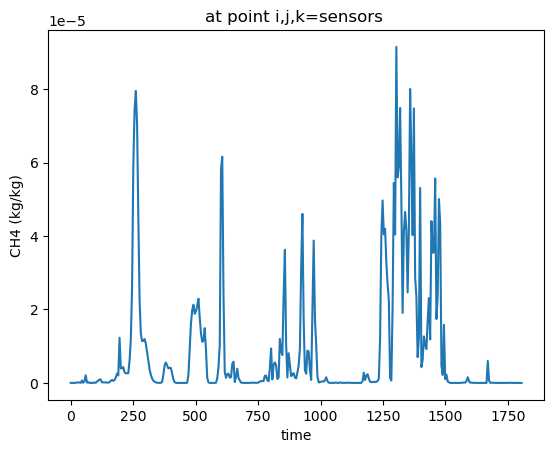

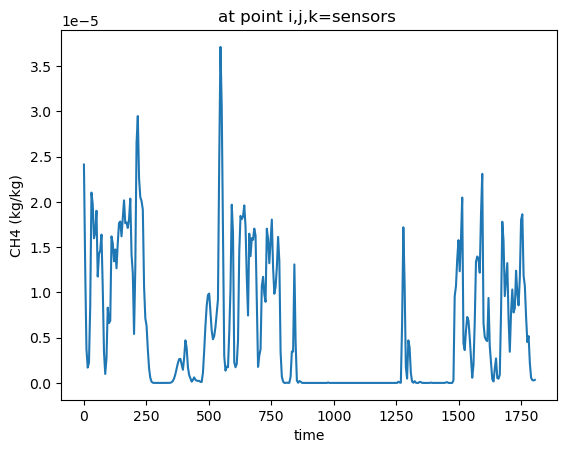

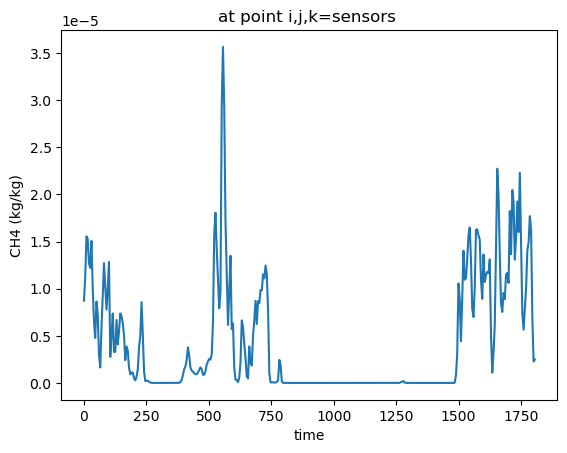

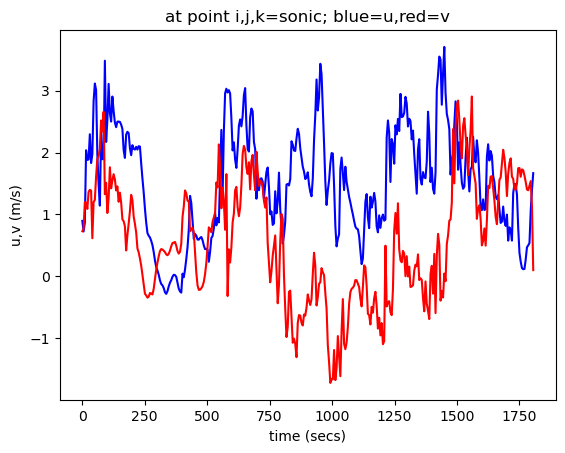

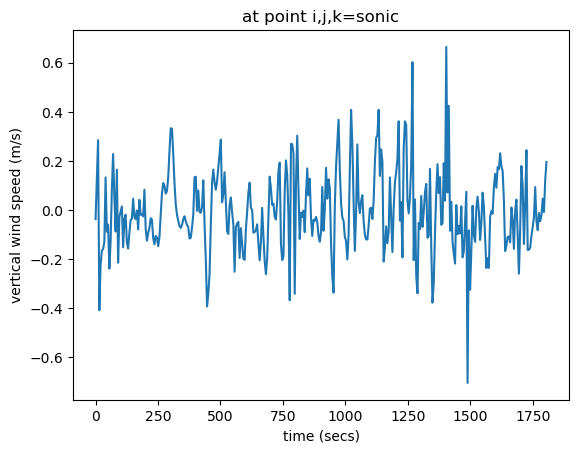

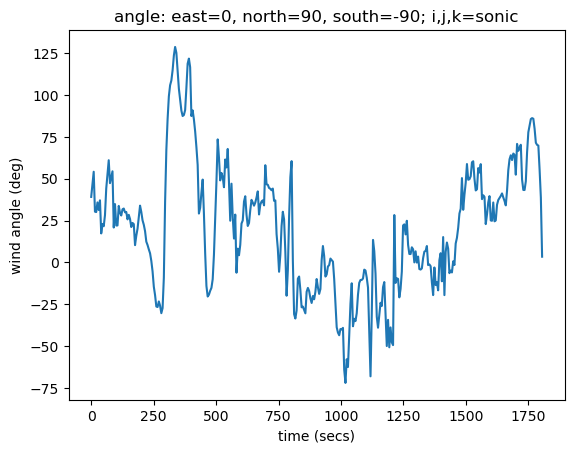

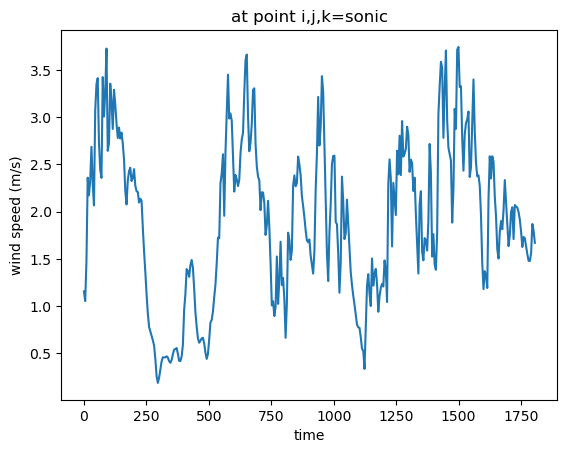

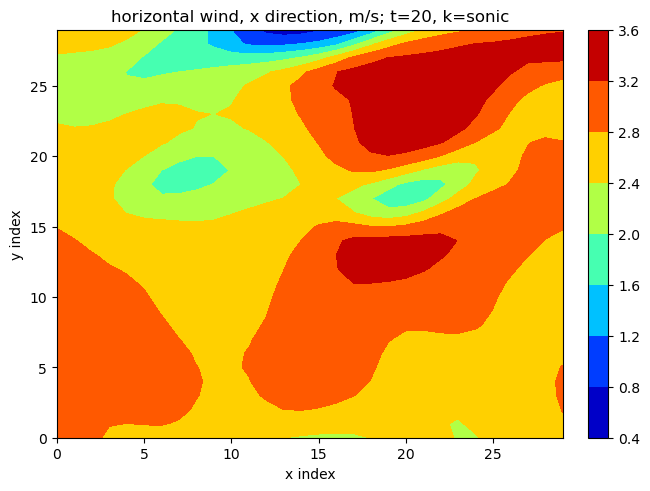

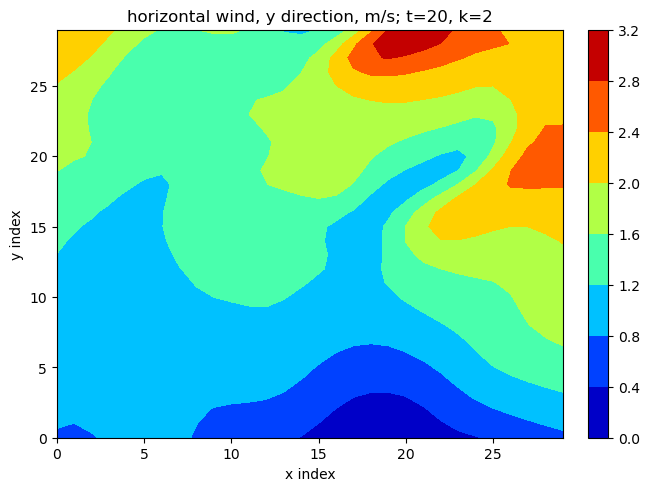

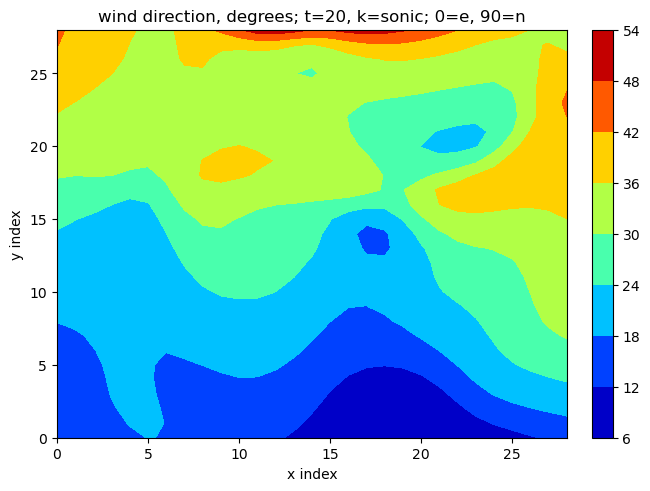

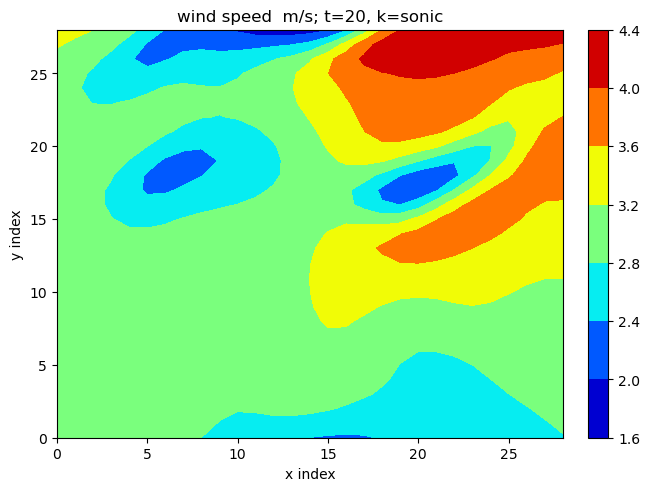

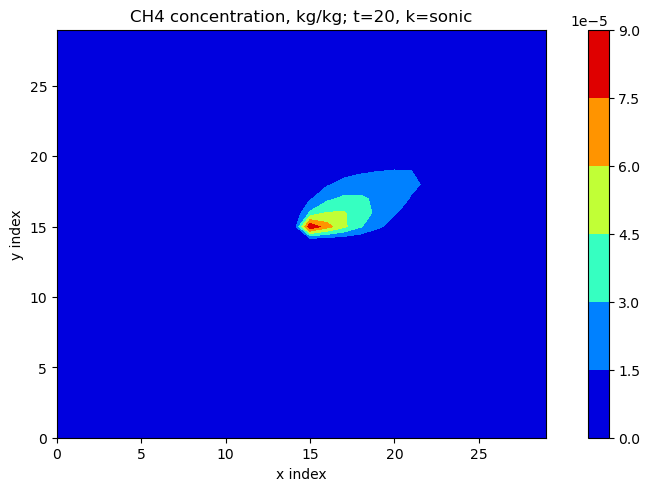

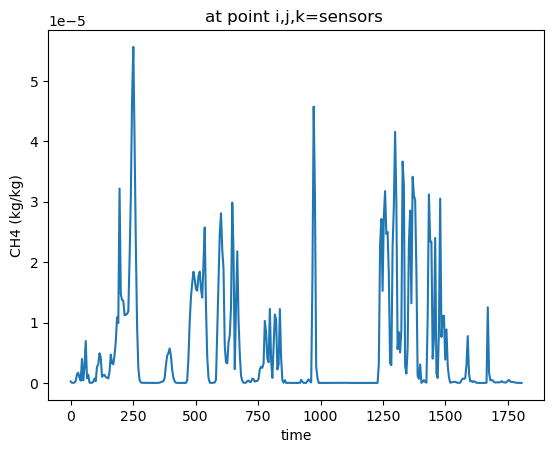

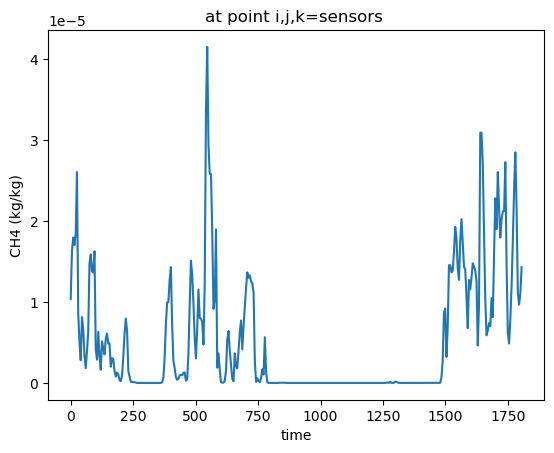

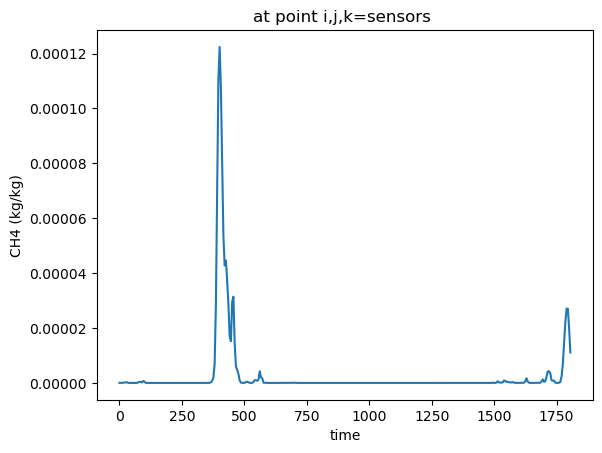

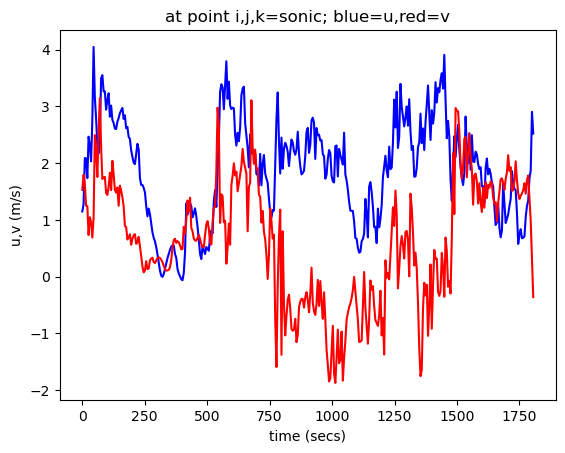

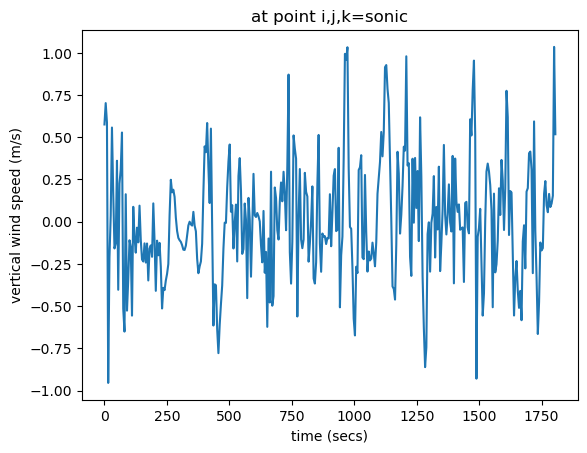

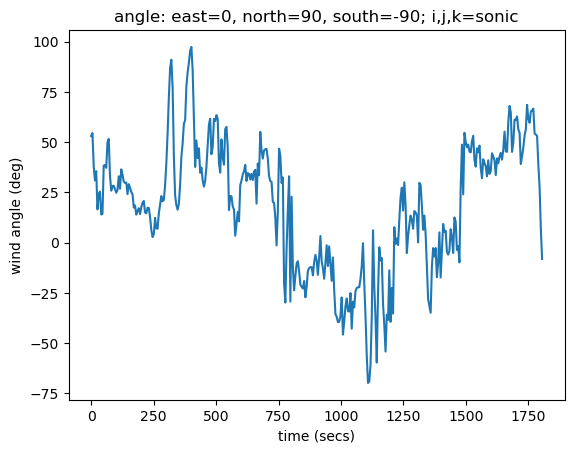

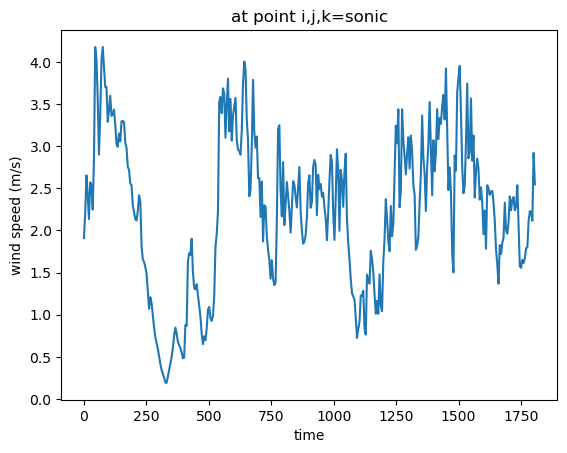

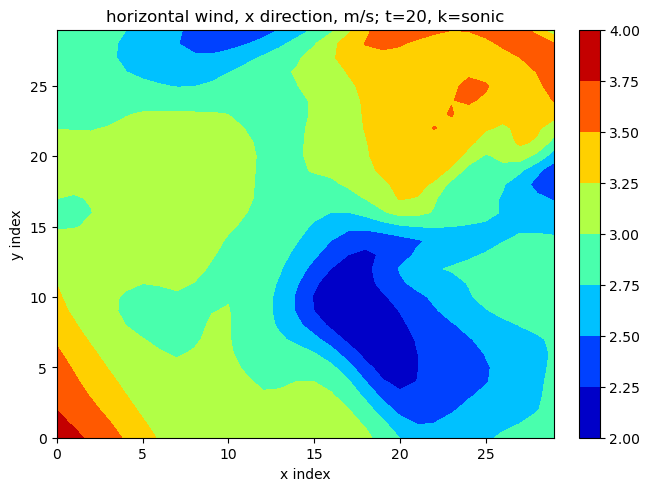

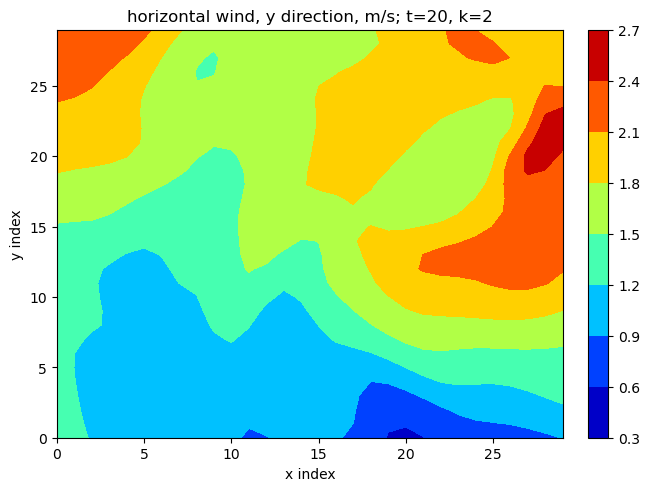

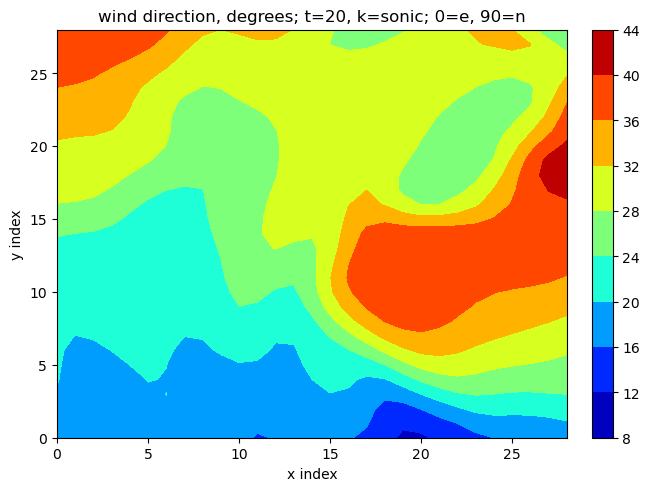

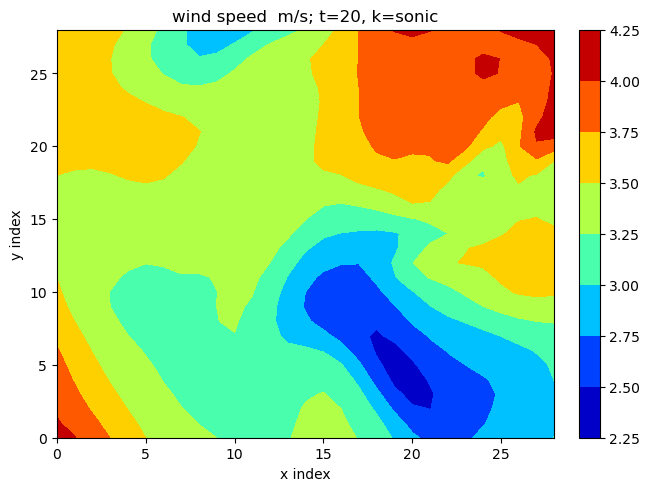

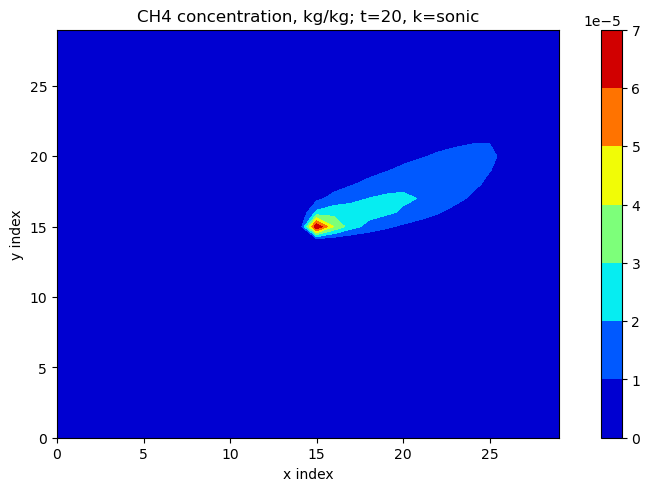

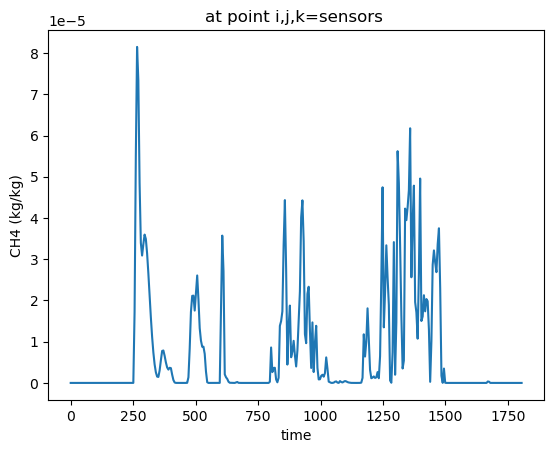

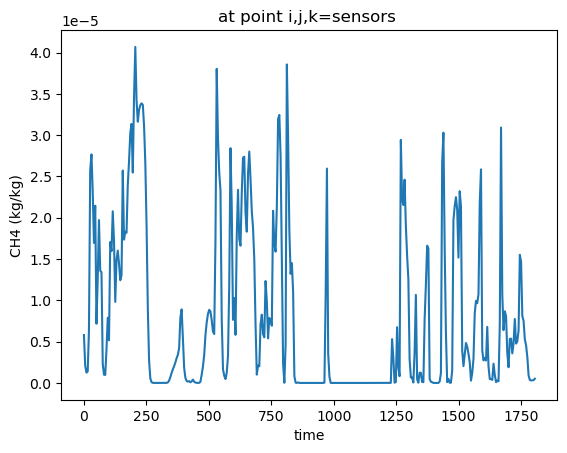

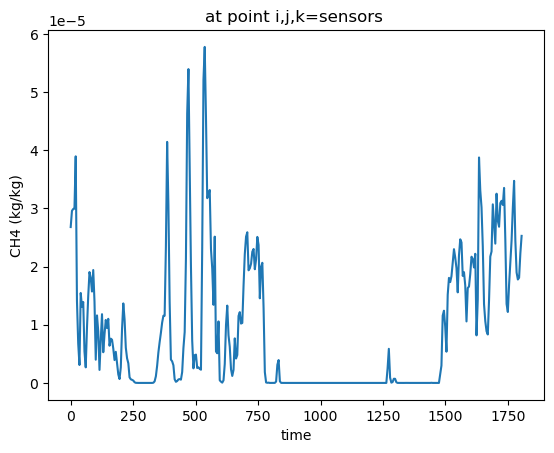

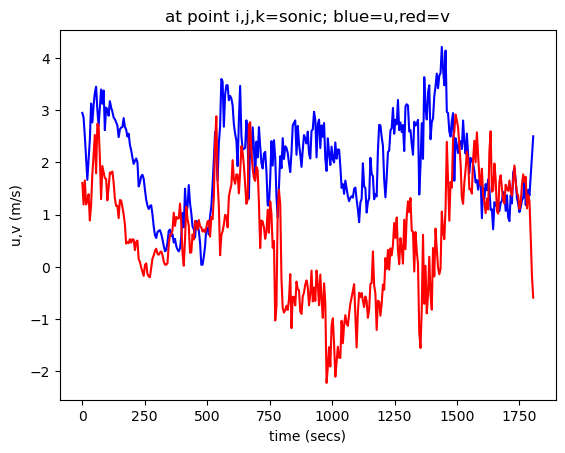

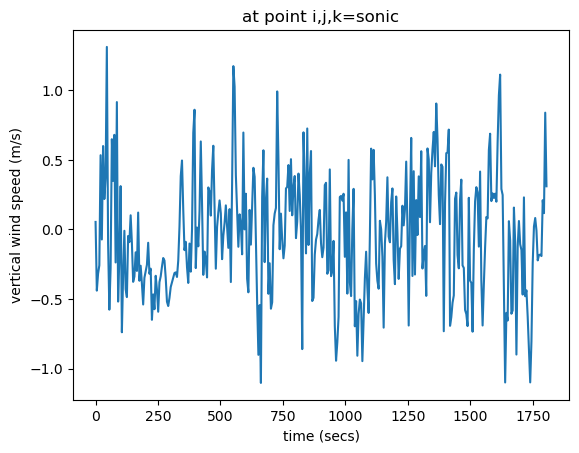

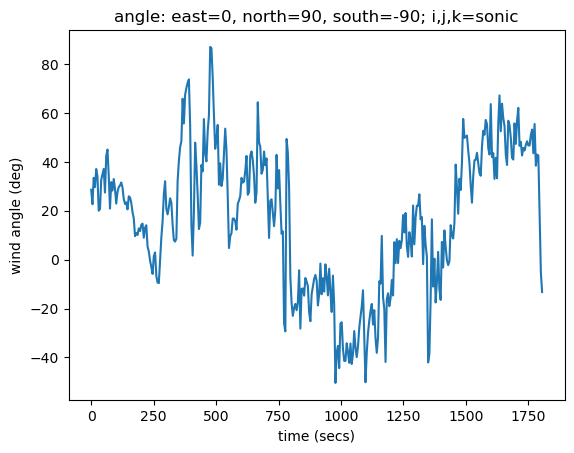

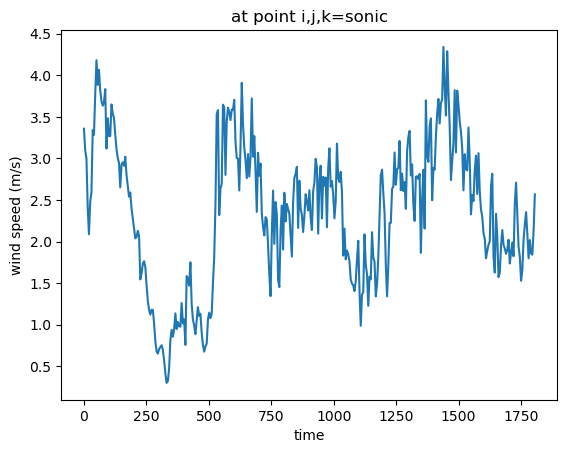

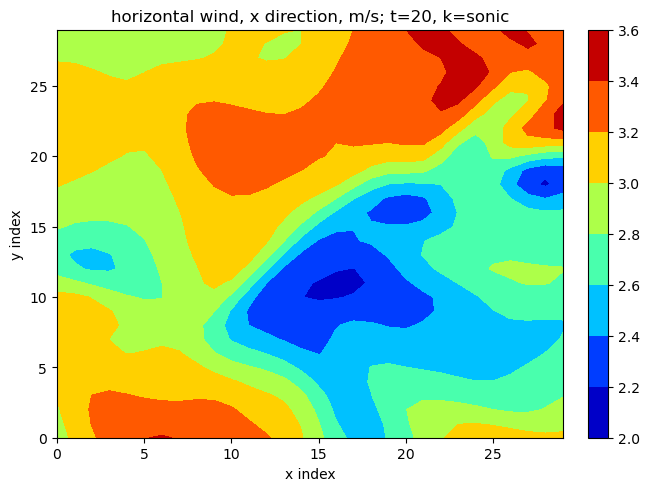

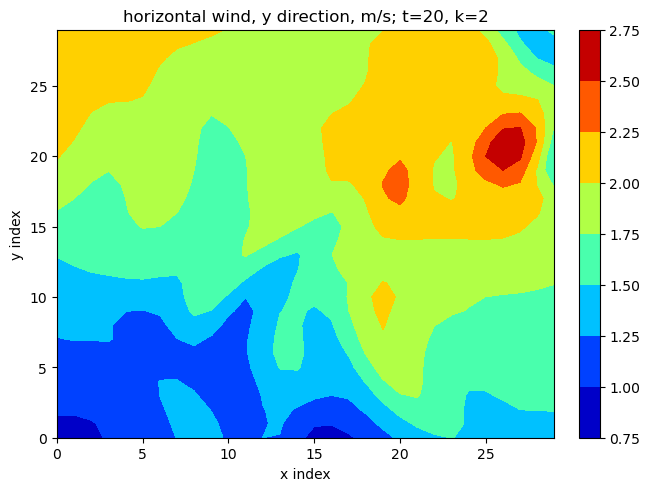

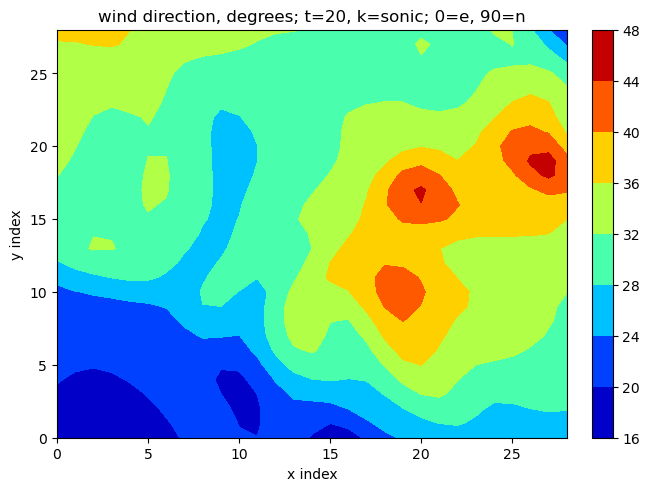

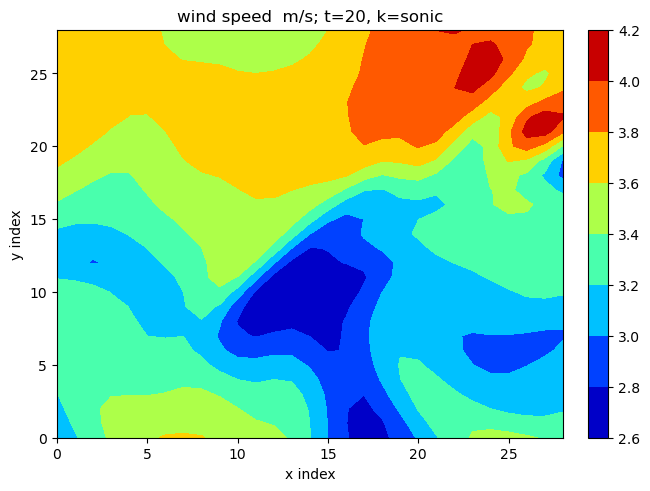

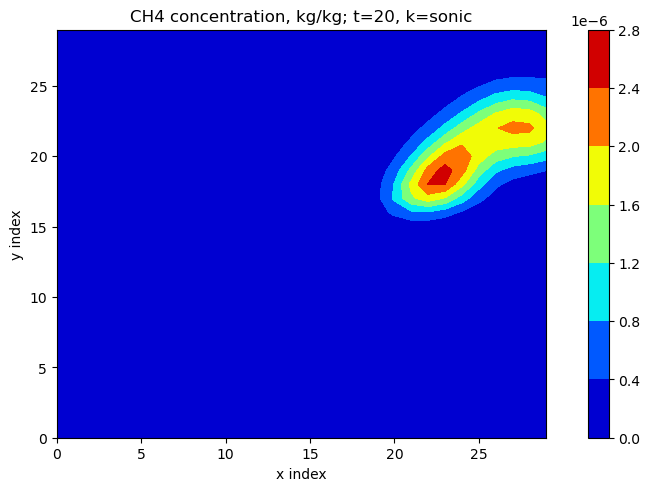

record number index, shuffled index = 6 538
opened file= /glade/scratch/jsauer/ForPeople/ForCAMS/SET_10_12_23/SBL/SBL2m_Ug5_src1-8kg_b.5
t_zero,times[nt1],dt,timescale;xyzscale= 30600.002 32400.002 5.0 1800.0 60.0
record number index, shuffled index = 7 176
opened file= /glade/scratch/jsauer/ForPeople/ForCAMS/SET_10_12_23/CBL/CBL2m_Ug10_src1-8kg_a.6
t_zero,times[nt1],dt,timescale;xyzscale= 14400.001 16200.001 5.0 1800.0 60.0
record number index, shuffled index = 8 299
opened file= /glade/scratch/jsauer/ForPeople/ForCAMS/SET_10_12_23/CBL/CBL2m_Ug3p6_src1-8kg_b.3
t_zero,times[nt1],dt,timescale;xyzscale= 16200.001 18000.0 5.0 1799.999 60.0
record number index, shuffled index = 9 220
opened file= /glade/scratch/jsauer/ForPeople/ForCAMS/SET_10_12_23/CBL/CBL2m_Ug2p5_src10kg_a.2
t_zero,times[nt1],dt,timescale;xyzscale= 14400.001 16200.001 5.0 1800.0 60.0
record number index, shuffled index = 10 327
opened file= /glade/scratch/jsauer/ForPeople/ForCAMS/SET_10_12_23/DC/DC_Ug7p5_src_9_10kg_hour_0

2023-12-12 13:27:59.814692: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 13:27:59.819236: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 13:27:59.857862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 13:27:59.857920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 13:27:59.859324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 11492 (44.89 KB)
Trainable params: 11492 (44.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-12 13:28:04.081197: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


None
n_ins,total_files,total_inputs,splitting= 14 696 6264 5643
Epoch 1/200
4514/4514 [==============================] - 7s 1ms/step - loss: 0.4382 - mse: 0.0048 - val_loss: 0.4378 - val_mse: 0.0024
Epoch 2/200
4514/4514 [==============================] - 6s 1ms/step - loss: 0.4295 - mse: 0.0023 - val_loss: 0.4372 - val_mse: 0.0023
Epoch 3/200
4514/4514 [==============================] - 8s 2ms/step - loss: 0.4287 - mse: 0.0022 - val_loss: 0.4368 - val_mse: 0.0022
Epoch 4/200
4514/4514 [==============================] - 6s 1ms/step - loss: 0.4277 - mse: 0.0020 - val_loss: 0.4348 - val_mse: 0.0018
Epoch 5/200
4514/4514 [==============================] - 6s 1ms/step - loss: 0.4265 - mse: 0.0017 - val_loss: 0.4339 - val_mse: 0.0017
Epoch 6/200
4514/4514 [==============================] - 6s 1ms/step - loss: 0.4255 - mse: 0.0016 - val_loss: 0.4329 - val_mse: 0.0014
Epoch 7/200
4514/4514 [==============================] - 6s 1ms/step - loss: 0.4249 - mse: 0.0014 - val_loss: 0.4325 - val_mse

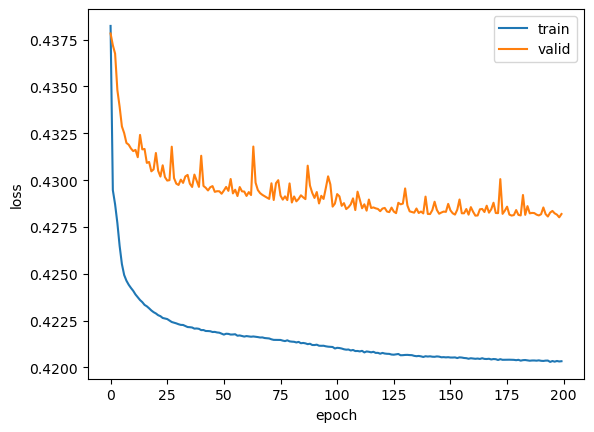

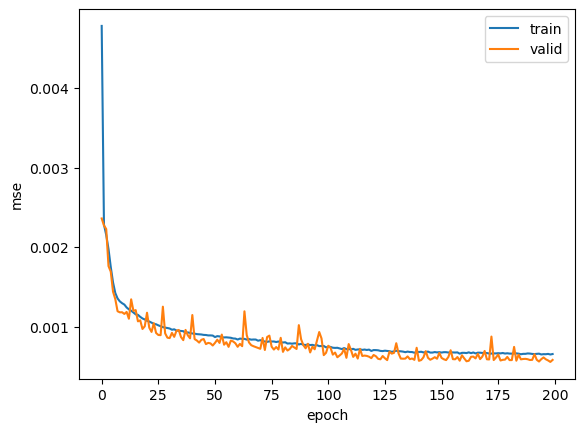

5643/5643 [==============================] - 5s 882us/step


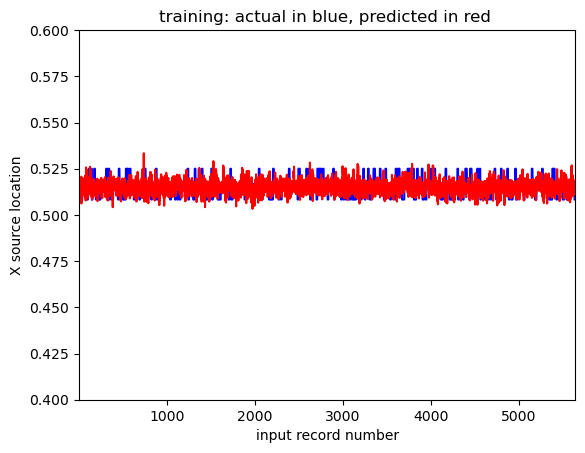

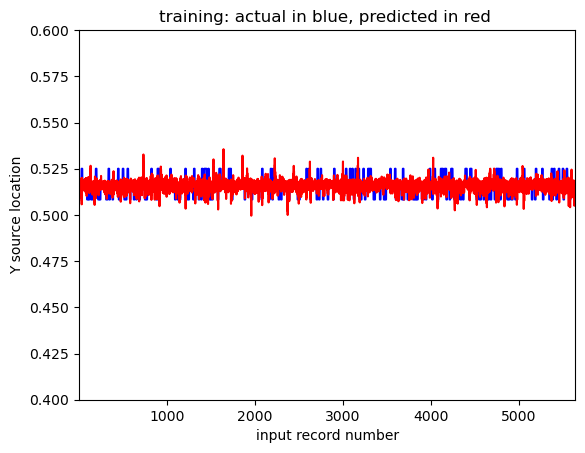

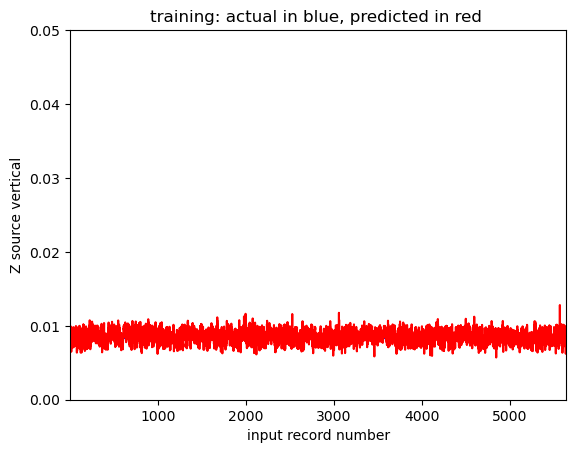

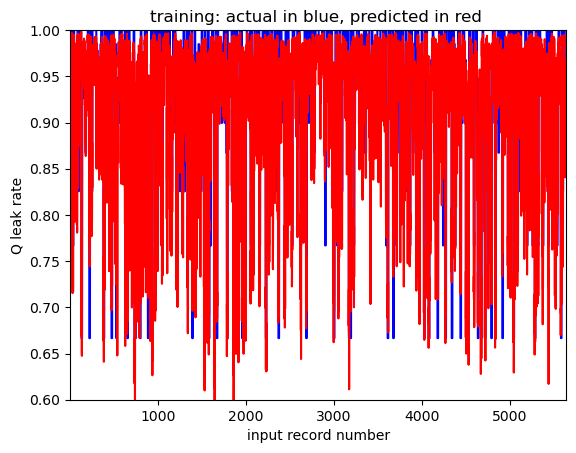

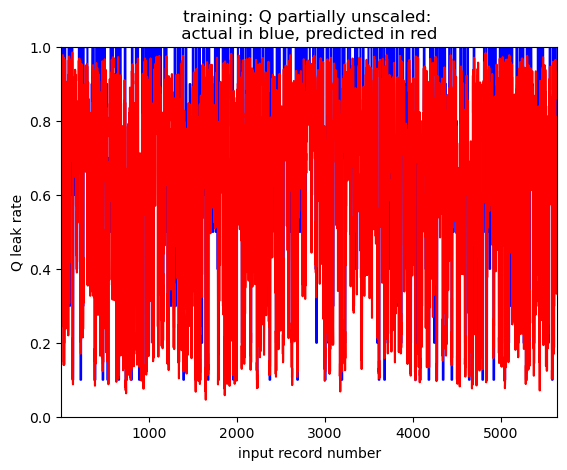

 rmse = 0.024931122782594125


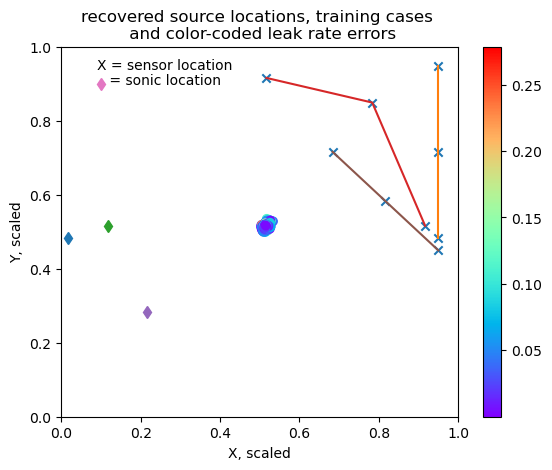

621/621 [==============================] - 1s 908us/step


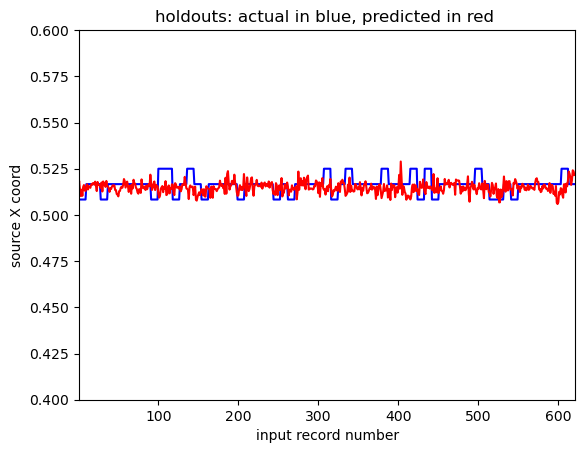

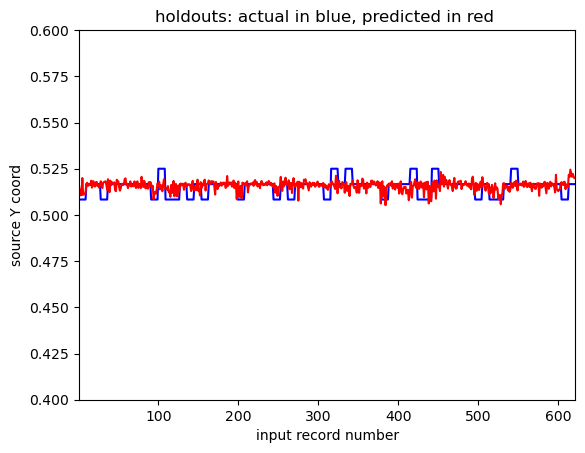

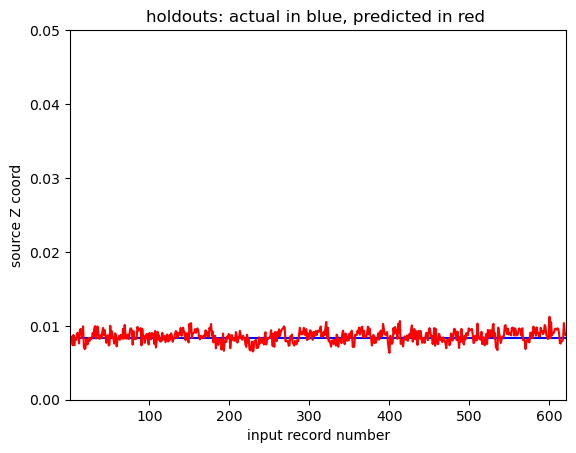

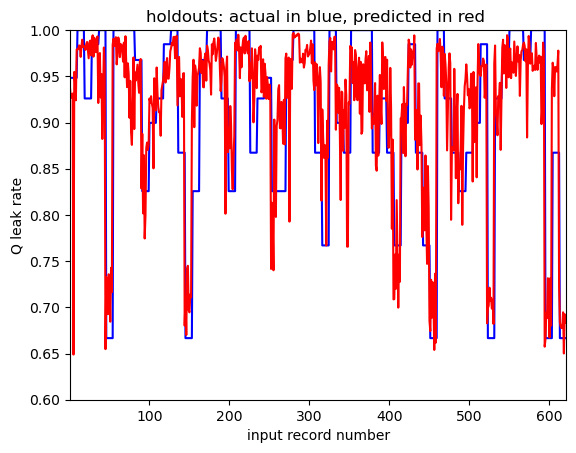

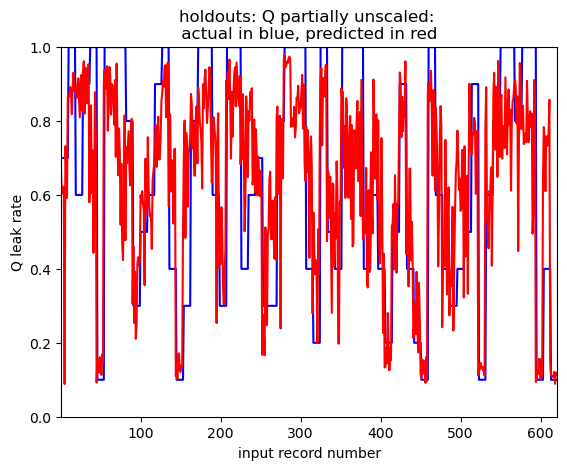

 rmse =  0.025645494077902523


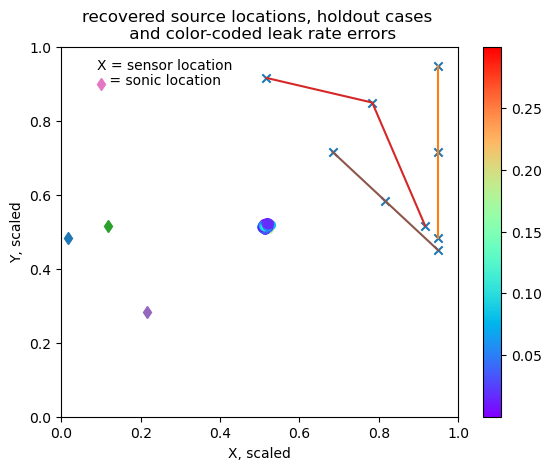

In [24]:
# shuffle list of indices for file names
        
ij_shuffled=np.arange(0,total_files,1)

print('ij_shuffled:before=',ij_shuffled)

random.shuffle(ij_shuffled)

print('ij_shuffled:after=',ij_shuffled)
    
# beginning of loop over files to process
# will read in one at a time, pull out data
# add to NN input, output vectors
# after loop, need to scale C, Q and (u,v,w)
    
for count in range(0,total_files):
    
    i=ij_shuffled[count]
            
    print('record number index, shuffled index =',count,i)
        
    b=xr.open_dataset(files_l[i])

    print('opened file=',files_l[i])

    # get dimensions of domain in each coord.
        
    xvals=b.xPos.isel(kDim=1,jDim=1).values
    nx=len(xvals)
    nx1=nx-1
    x_cellwidth=xvals[1]-xvals[0]

    yvals=b.yPos.isel(kDim=1,iDim=1).values
    ny=len(yvals)
    ny1=ny-1
    y_cellwidth=yvals[1]-yvals[0]

    zvals=b.zPos.isel(jDim=1,iDim=1).values
    nz=len(zvals)
    nz1=nz-1
    z_cellwidth=zvals[1]-zvals[0]

    # define ref point - lower left bottom corner
        
    xref=xvals[0]-x_cellwidth/2
    yref=yvals[0]-y_cellwidth/2
    zref=max(0.,zvals[0]-z_cellwidth/2.)

    # scales in each coord. = size of domain
        
    x_width=xvals[nx1]-xvals[0]+x_cellwidth
    y_width=yvals[ny1]-yvals[0]+y_cellwidth
    z_width=zvals[nz1]-zvals[0]+z_cellwidth

    xyzscale=max(x_width,y_width,z_width)
    
    # pull out time sequence, set reference time, time scale
    # assumes time points are equally spaced
        
    times=b.time.values
    ntimes=len(times)
    nt1=ntimes-1
    t_zero=times[0]
    time_scale=times[nt1]-t_zero
    dt=times[1]-times[0]   

    print('t_zero,times[nt1],dt,timescale;xyzscale=',t_zero,times[nt1],dt,time_scale,xyzscale)
        
    # scale sensor locations

    subs=-1
    for k in range(0,number_sensors):
        for k2 in range(0,number_sensor_sets):
            subs+=1
            sensor_x_scl[subs]=(sensor_x_i[subs]-0.5)*x_cellwidth/xyzscale
            sensor_y_scl[subs]=(sensor_y_i[subs]-0.5)*x_cellwidth/xyzscale
            sensor_z_scl[subs]=(sensor_z_i[subs]-0.5)*z_cellwidth/xyzscale
            
    b.srcAuxScLocation
        
        # get x,y,z and q for source

    q_source=b.srcAuxScMassSpecValue.values[0]
    x_source=b.srcAuxScLocation.values[0,0]
    y_source=b.srcAuxScLocation.values[0,1]
    z_source=b.srcAuxScLocation.values[0,2]
        
    # scale source position variables

    x_source_scl=(x_source-xref)/xyzscale
    y_source_scl=(y_source-yref)/xyzscale
    z_source_scl=(z_source-zref)/xyzscale

    # track maximum leak rate, to use for scaling
        
    Q_leak_max_global=max(Q_leak_max_global,q_source)
        
    # pull out CH4 data (x,y,z,t)
        
    b.q_CH4

    for m2 in range(0,number_sensor_sets):
            
    # pull out time series at sensor points

        m3=m2*3
        for m in range(0,number_sensors):
            subm=m3+m
            b_ts_ch4_sensor_i[m]=b.q_CH4.isel(kDim=sensor_z_i[subm], jDim=sensor_y_i[subm], iDim=sensor_x_i[subm]).values

        # get u,v vs t at sonic location
        
        b_ts_u_sonic=b.u.isel(kDim=sonic_loc[m3], jDim=sonic_loc[m3+1], iDim=sonic_loc[m3+2]).values
        b_ts_v_sonic=b.v.isel(kDim=sonic_loc[m3], jDim=sonic_loc[m3+1], iDim=sonic_loc[m3+2]).values   
        b_ts_w_sonic=b.w.isel(kDim=sonic_loc[m3], jDim=sonic_loc[m3+1], iDim=sonic_loc[m3+2]).values

        # convert u,v to angle,speed
        
        angle=np.zeros(ntimes)
        speed=np.zeros(ntimes)
        out=polar(angle,speed,b_ts_u_sonic,b_ts_v_sonic,ntimes)

        # make some plots
        
        if count == pick:
            
        # pull out a u field at early time for look-see
        
            b_2d_xy_u_t20sonic=b.u.isel(timeDim=20, kDim=sonic_loc[m3]).values

            # pull out a v field at same early time
        
            b_2d_xy_v_t20sonic=b.v.isel(timeDim=20, kDim=sonic_loc[m3]).values

            # convert to angle,speed fields
        
            speed2d=np.zeros((nx1,ny1))
            angle2d=np.zeros((nx1,ny1))
            out2d=polar2d(angle2d,speed2d,b_2d_xy_u_t20sonic,b_2d_xy_v_t20sonic,nx1,ny1)
        
            # pull out an x-y CH4 field at same early time on bottom layer to see plume
        
            b_2d_xy_qch4_t20sonic=b.q_CH4.isel(time=20, kDim=sonic_loc[m3]).values
        
            # horizontal wind components vs time

            # make some plots to see what CH4 and winds v time looks like

            for mm in range(0,number_sensors):
                
                x=np.linspace(0,ntimes*dt,ntimes)
                plt.xlabel('time')
                plt.ylabel('CH4 (kg/kg)')
                plt.title('at point i,j,k=sensors ')
                plt.plot(x,b_ts_ch4_sensor_i[mm])
                plt.show()
                
            plt.xlabel('time (secs)')
            plt.ylabel('u,v (m/s)')
            plt.title('at point i,j,k=sonic; blue=u,red=v')
            plt.plot(x,b_ts_u_sonic,'b',x,b_ts_v_sonic,'r')
            plt.show()
            
            plt.xlabel('time (secs)')
            plt.ylabel('vertical wind speed (m/s)')
            plt.title('at point i,j,k=sonic')
            plt.plot(x,b_ts_w_sonic)
            plt.show()
            
            # plot wind angle vs time
        
            plt.xlabel('time (secs)')
            plt.ylabel('wind angle (deg)')
            plt.title('angle: east=0, north=90, south=-90; i,j,k=sonic')
            plt.plot(x,angle)
            plt.show()
            
            # plot wind speed vs time
        
            plt.xlabel('time')
            plt.ylabel('wind speed (m/s)')
            plt.title('at point i,j,k=sonic')
            plt.plot(x,speed)
            plt.show()
            
            # contour plots of  winds on a plane early time
            
            fig1,ax2=plt.subplots(layout='constrained')
            xx=np.arange(0,30*x_cellwidth,30)
            yy=xx
            ax2.set_xlabel('x index')
            ax2.set_ylabel('y index')
            ax2.set_title('horizontal wind, x direction, m/s; t=20, k=sonic')
            cs=plt.contourf(b_2d_xy_u_t20sonic,cmap=plt.cm.jet)
            cbar=fig1.colorbar(cs)
            plt.show()
            
            fig1,ax2=plt.subplots(layout='constrained')
            xx=np.arange(0,30*x_cellwidth)
            yy=xx
            ax2.set_xlabel('x index')
            ax2.set_ylabel('y index')
            ax2.set_title('horizontal wind, y direction, m/s; t=20, k=2')
            cs=plt.contourf(b_2d_xy_v_t20sonic,cmap=plt.cm.jet)
            cbar=fig1.colorbar(cs)
            plt.show()
            
            # plot angle field
        
            fig1,ax2=plt.subplots(layout='constrained')
            xx=np.arange(0,30*x_cellwidth)
            yy=xx
            ax2.set_xlabel('x index')
            ax2.set_ylabel('y index')
            ax2.set_title('wind direction, degrees; t=20, k=sonic; 0=e, 90=n')
            cs=plt.contourf(angle2d,cmap=plt.cm.jet)
            cbar=fig1.colorbar(cs)
            plt.show()
            
            # plot speed field
        
            fig1,ax2=plt.subplots(layout='constrained')
            xx=np.arange(0,30*x_cellwidth)
            yy=xx
            ax2.set_xlabel('x index')
            ax2.set_ylabel('y index')
            ax2.set_title('wind speed  m/s; t=20, k=sonic')
            cs=plt.contourf(speed2d,cmap=plt.cm.jet)
            cbar=fig1.colorbar(cs)
            plt.show()
            
            # plot CH4 field at early time
            
            fig1,ax2=plt.subplots(layout='constrained')
            xx=np.arange(0,30)
            yy=xx
            ax2.set_xlabel('x index')
            ax2.set_ylabel('y index')
            ax2.set_title('CH4 concentration, kg/kg; t=20, k=sonic')
            cs=plt.contourf(b_2d_xy_qch4_t20sonic,cmap=plt.cm.jet)
            cbar=fig1.colorbar(cs)
            plt.show()
        
        # initialize some vectors, arrays
        
        CH4max=np.empty(shape=[number_sensors])
        time_CH4max=np.empty(shape=[number_sensors])
        ijkmax=np.empty(shape=[number_sensors],dtype=int)
        avg_speed=np.empty(shape=[number_sensors])
        avg_angle=np.empty(shape=[number_sensors])
        CH4_assoc=np.empty(shape=[number_sensors,number_sensors])
        time_assoc=np.empty(shape=[number_sensors,number_sensors])

        # specify stopping points for backtracking
        
        min_x=factor*xyzscale
        min_y=factor*xyzscale

        # get max CH4 and corresponding time and ijk for each sensor location
        
        for ii in range(0,number_sensors):
            
            outC=findmaxC(b_ts_ch4_sensor_i[ii],times,ntimes)
            
            CH4max[ii]=outC[0]
            time_CH4max[ii]=outC[1]
            ijkmax[ii]=outC[2]

#            print('i,ii,out=',i,ii,outC)
            
            # capture global max

            CH4_max_global=max(CH4_max_global,outC[0])
            
            # find average velocity over backtrack interval
            # met sensor could be some distance from CH4 sensors
            # could include a lag time ~ time for winds at met to reach 
            # CH4 sensors
            
            uvavg=backtrack(ijkmax[ii],b_ts_u_sonic,b_ts_v_sonic,dt,
                sensor_x_scl[ii]*xyzscale,sensor_y_scl[ii]*xyzscale,min_x,min_y)
            ux_avg=uvavg[0]
            vy_avg=uvavg[1]
            
            avg_speed[ii]=np.sqrt(ux_avg**2 + vy_avg**2)
            avg_angle[ii]=math.degrees(math.atan2(vy_avg,ux_avg))

#            print('i,ii,uxavg,vyavg,ijkmax=',i,ii,ux_avg,vy_avg,ijkmax[ii])
#            print('   uvavg.0.1=',uvavg[0],uvavg[1])
            
            speed_max=max(speed_max,avg_speed[ii])
            
        # find concentrations at other sensors j != i corresponding to peak time at sensor i
     
        for ii in range(0,number_sensors):
            CH4_assoc[ii][ii]=CH4max[ii]
            time_assoc[ii][ii]=time_CH4max[ii]
            for jj in range(0,number_sensors):
                if jj != ii:
                    CH4_assoc[ii][jj]=b_ts_ch4_sensor_i[jj][ijkmax[ii]]
                    time_assoc[ii][jj]=times[ijkmax[ii]]
                  
        # fill in input vector
        # have number_sensors records for each case (case = a file)
        
        for ii in range(0,number_sensors):
            
            ncns=count*number_sensors*number_sensor_sets+m3+ii
                  
            v_input[0][ncns]=avg_speed[ii]

            # scale wind angle after shifting to 0-360
            # and shifting again so that south pole = 0 degrees
            # angles measured counter clockwise
            
            if avg_angle[ii] < 0.:
                avg_angle[ii]+=360.
            avg_angle[ii]+=90.
            if avg_angle[ii] > 360.:
                avg_angle[ii]-=360.
            
            v_input[1][ncns]=avg_angle[ii]/360.

#            print('i,ii,v.input.0.1=',i,ii,v_input[0][ncns],v_input[1][ncns])
#            print('ncns,avg_speed,avg_angle.ii=',ncns,avg_speed[ii],avg_angle[ii])
            
            for pq in range(0,number_sensors):
                v_input[pq*4+2][ncns]=sensor_x_scl[m3+pq]
                v_input[pq*4+3][ncns]=sensor_y_scl[m3+pq]
                v_input[pq*4+4][ncns]=sensor_z_scl[m3+pq]
                v_input[pq*4+5][ncns]=CH4_assoc[ii][pq]
                
        # save source info into learning target array
        
            v_output[0][ncns]=x_source_scl
            v_output[1][ncns]=y_source_scl
            v_output[2][ncns]=z_source_scl
            v_output[3][ncns]=q_source
        
    b.close()

# form scaling factors for CH4 and leak rate Q

Q_scale=np.log10(Q_leak_max_global/Q_leak_min)
CH4_scale=np.log10(CH4_max_global/CH4_threshhold)

print('CH4.max.global,Q.leak.max.global,speed_max=',CH4_max_global,Q_leak_max_global,speed_max)
print('CH4_scale,Q_scale=',CH4_scale,Q_scale)

# scale CH4 and Q_leak values and wind speed

total_inputs=total_files*number_sensors*number_sensor_sets

n_ins=4*number_sensors+2

for m in range(0,total_inputs):
    v_output[3][m]=np.log10(max(v_output[3][m],Q_leak_min)/Q_leak_min)/Q_scale
    v_input[0][m]=v_input[0][m]/speed_max

#    print('m,v_output[3][m],v_input[0][m]=',m,v_output[3][m],v_input[0][m])
    
    for pq in range(0,number_sensors):
        v_input[pq*4+5][m]=np.log10(max(v_input[pq*4+5][m],CH4_threshhold)/CH4_threshhold)/CH4_scale
        
#        print('pq,v_input[pq*4+5][m]==',pq,v_input[pq*4+5][m])
        
# set up NN (or other learning algorithm)

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras import backend
#from keras_nlp.layers import TransformerDecoder, TransformerEncoder

!pip install keras
!pip install tensorflow
import tensorflow as tf
import keras.layers as layers
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

model=Sequential()

#model.add(Input(shape=(total_inputs,n_ins)))
model.add(Input(shape=(n_ins,)))

# add input layer
model.add(Dense(activation = 'relu', units=64))

#Add 1st hidden layer; how big should it be?
model.add(Dense(64, activation='relu'))

#Add 2nd hidden layer; how big should it be?
model.add(Dense(64, activation='relu'))

#Add 3rd hidden layer; how big should it be?
model.add(Dense(32, activation='relu'))

# Adding the output layer
model.add(Dense(4,activation='sigmoid'))

# Create optimizer with default learning rate
# Compile the model
# using regular SGD; batch_size=1 so loss and metrics only done over a batch?
# would be best if over all batches. will add custom loss and metrics, but for now ...

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['mse'])

print(model.summary())

# split data into training and testing and prediction
# want to split between files, not within group of records
# corresponding to a file

# holdouts = number of records to hold back, use for testing
# data = full set of info for all records, files
# train = data less holdouts
# model.fit will use some of 'train' info for validation

holdouts=int(prcnt*total_files)*number_sensors*number_sensor_sets
splitting=total_inputs-holdouts

X_data=np.empty(shape=[total_inputs,n_ins])
y_data=np.empty(shape=[total_inputs,4])

X_train=np.empty(shape=[splitting,n_ins])
y_train=np.empty(shape=[splitting,4])

X_holdout=np.empty(shape=[holdouts,n_ins])
y_holdout=np.empty(shape=[holdouts,4])

y_pred_all=np.empty(shape=[splitting,4])

print('n_ins,total_files,total_inputs,splitting=',n_ins,total_files,total_inputs,splitting)

# fill in X_train, y_train from v_input and v_output

for i in range(total_inputs):
    for j in range(n_ins):
        X_data[i][j]=v_input[j][i]
    for k in range(4):
        y_data[i][k]=v_output[k][i]

# partition data into training plus holdout. holdout will be used as 
# final test of fit again 'unseen' data. train data will be further
# partitioned by model.fit through the validation_split parameter

#X_train, X_holdout, y_train, y_holdout= train_test_split(X_data,y_data,test_size=prcnt) - not in keras

for i in range(splitting):
#    print('i in splitting=',i)
    for j in range(n_ins):
        X_train[i][j]=X_data[i][j]
    for k in range(4):
        y_train[i][k]=y_data[i][k]

# holding out last prcnt fraction of files

for i in range(splitting,total_inputs):
#    print('i, i - splitting+ =',i,i-splitting)
    for j in range(n_ins):
        X_holdout[i-splitting][j]=X_data[i][j]
    for k in range(4):
        y_holdout[i-splitting][k]=y_data[i][k]
        
#    train the model. train data is split into two parts - actual training plus validation

history=model.fit(X_train, y_train,validation_split=0.2,batch_size=1,epochs=200,verbose=1)

# Capturing learning history per epoch

hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

# Plotting loss function and accuracy vs epochs
# but these are for a batch, and batch_size = 1 here
# so these are not very meaningful. Need to sum over
# all batches

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc ="upper right")
plt.show()

plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(hist['mse'])
plt.plot(hist['val_mse'])
plt.legend(("train" , "valid") , loc ="upper right")
plt.show()

# apply model to training set to see how well/poorly true values are recovered

y_pred_all=model.predict(X_train,batch_size=1)

# print true vs predicted for x,y locations and leak rate

#print(' X.true,X.pred;Y.true,Y.pred;Z.true,Z.pred;Q.true,Q.pred')
#for i in range(splitting):
#    e=[y_train[i][0],y_pred_all[i][0],y_train[i][1],y_pred_all[i][1],y_train[i][2],y_pred_all[i][2],y_train[i][3],y_pred_all[i][3]]
#    print([round(x,2) for x in e])

# plot individual features - all variables plotted are still scaled

x=np.linspace(1,splitting,splitting)

y_diff2=0.
y_actual=np.empty(shape=[splitting])
y_model=np.empty(shape=[splitting])
var_range=np.empty(shape=[4,2])
label=['X source location','Y source location','Z source vertical','Q leak rate']
var_range=[[.4,.6],[.4,.6],[0.,.05],[.6,1.]]

for k in range(0,4):
    for i in range(splitting):
        y_diff2+=(y_train[i][k]-y_pred_all[i][k])**2
        y_actual[i]=y_train[i][k]
        y_model[i]=y_pred_all[i][k]

    plt.axis([1,splitting,var_range[k][0],var_range[k][1]])
    plt.xlabel('input record number')
    plt.ylabel(label[k])
    plt.title('training: actual in blue, predicted in red ')
    plt.plot(x,y_actual,'b',y_model,'r')
    plt.show()

rmse=np.sqrt(y_diff2/float(4.*splitting))

for i in range(splitting):
    y_actual[i]=10.**(y_train[i][3]*Q_scale)*Q_leak_min/Q_leak_max_global
    y_model[i]=10.**(y_pred_all[i][3]*Q_scale)*Q_leak_min/Q_leak_max_global

plt.axis([1,splitting,0.,1.])
plt.xlabel('input record number')
plt.ylabel(label[3])
plt.title('training: Q partially unscaled: \n actual in blue, predicted in red ')
plt.plot(x,y_actual,'b',y_model,'r')
plt.show()

print(' rmse =',rmse)

# scatterplot for recovered x,y source locations 
# leak rate recovery accuracy reflected in color of
# circles - color reflects error 

x_scttr=np.empty(shape=[splitting])
y_scttr=np.empty(shape=[splitting])
color=np.empty(shape=[splitting])

for i in range(0,splitting):
    x_scttr[i]=y_pred_all[i][0]
    y_scttr[i]=y_pred_all[i][1]
    color[i]=abs(y_train[i][3] - y_pred_all[i][3])

plt.axis([0.,1.,0.,1.])
plt.xlabel('X, scaled')
plt.ylabel('Y, scaled')
plt.title('recovered source locations, training cases \n and color-coded leak rate errors')
plt.scatter(sensor_x_scl,sensor_y_scl,marker='x')
for mk in range(0,number_sensor_sets):
    mk3=mk*number_sensors
    sonic_x=(sonic_loc[mk3]-0.5)*x_cellwidth/xyzscale
    sonic_y=(sonic_loc[mk3+1]-0.5)*y_cellwidth/xyzscale
    plt.plot(sonic_x,sonic_y,marker='d')
    path_x=np.zeros(shape=[number_sensors])
    path_y=np.zeros(shape=[number_sensors])
    for mj in range(0,number_sensors):
        path_x[mj]=sensor_x_scl[mk3+mj]
        path_y[mj]=sensor_y_scl[mk3+mj]
    plt.plot(path_x,path_y)
plt.text(0.09,0.94,'X = sensor location')
plt.plot(0.10,0.90,marker='d')
plt.text(0.11,0.90,' = sonic location')
plt.scatter(x_scttr,y_scttr,c=color,cmap='rainbow')
plt.colorbar()
plt.show()

# apply model to holdout set to see how well/poorly model works for unseen data

y_pred_holdout=model.predict(X_holdout,batch_size=1)

# print true vs predicted for x,y,z coords of source and leak rate

#print(' for holdout data: \n X.true,X.pred;Y.true,Y.pred;Z.true,Z.pred;Q.true,Q.pred')
#for i in range(holdouts):
#    e=[y_holdout[i][0],y_pred_holdout[i][0],y_holdout[i][1],y_pred_holdout[i][1],y_holdout[i][2],y_pred_holdout[i][2],y_holdout[i][3],y_pred_holdout[i][3]]
#    print([round(x,2) for x in e])

# for holdouts, plot individual features - true vs predicted; all are still scaled, i.e., lie between 0 and 1.

x=np.linspace(1,holdouts,holdouts)

y_diffh2=0.
y_actual=np.empty(shape=[holdouts])
y_model=np.empty(shape=[holdouts])
var_range=np.empty(shape=[4,2])
label=['source X coord','source Y coord','source Z coord','Q leak rate']
var_range=[[.4,.6],[.4,.6],[0.,.05],[.6,1.]]

for k in range(0,4):
    for i in range(holdouts):
        y_diffh2+=(y_holdout[i][k]-y_pred_holdout[i][k])**2
        y_actual[i]=y_holdout[i][k]
        y_model[i]=y_pred_holdout[i][k]

    plt.axis([1,holdouts,var_range[k][0],var_range[k][1]])
    plt.xlabel('input record number')
    plt.ylabel(label[k])
    plt.title('holdouts: actual in blue, predicted in red ')
    plt.plot(x,y_actual,'b',y_model,'r')
    plt.show()

rmse=np.sqrt(y_diffh2/float(4.*holdouts))

for i in range(holdouts):
    y_actual[i]=10.**(y_holdout[i][3]*Q_scale)*Q_leak_min/Q_leak_max_global
    y_model[i]=10.**(y_pred_holdout[i][3]*Q_scale)*Q_leak_min/Q_leak_max_global

plt.axis([1,holdouts,0.,1.])
plt.xlabel('input record number')
plt.ylabel(label[3])
plt.title('holdouts: Q partially unscaled: \n actual in blue, predicted in red ')
plt.plot(x,y_actual,'b',y_model,'r')
plt.show()

print(' rmse = ',rmse)

# scatterplot for recovered x,y,z source locations 
# leak rate recovery accuracy reflected in color of
# circles - color reflects error 

x_scttr=np.empty(shape=[holdouts])
y_scttr=np.empty(shape=[holdouts])
color=np.empty(shape=[holdouts])

for i in range(0,holdouts):
    x_scttr[i]=y_pred_holdout[i][0]
    y_scttr[i]=y_pred_holdout[i][1]
    color[i]=abs(y_holdout[i][3] - y_pred_holdout[i][3])

plt.axis([0.,1.,0.,1.])
plt.xlabel('X, scaled')
plt.ylabel('Y, scaled')
plt.title('recovered source locations, holdout cases \n and color-coded leak rate errors')
plt.scatter(sensor_x_scl,sensor_y_scl,marker='x')
for mk in range(0,number_sensor_sets):
    mk3=mk*number_sensors
    sonic_x=(sonic_loc[mk3]-0.5)*x_cellwidth/xyzscale
    sonic_y=(sonic_loc[mk3+1]-0.5)*y_cellwidth/xyzscale
    plt.plot(sonic_x,sonic_y,marker='d')
    path_x=np.zeros(shape=[number_sensors])
    path_y=np.zeros(shape=[number_sensors])
    for mj in range(0,number_sensors):
        path_x[mj]=sensor_x_scl[mk3+mj]
        path_y[mj]=sensor_y_scl[mk3+mj]
    plt.plot(path_x,path_y)
plt.text(0.09,0.94,'X = sensor location')
plt.plot(0.10,0.90,marker='d')
plt.text(0.11,0.90,' = sonic location')
plt.scatter(x_scttr,y_scttr,c=color,cmap='rainbow')
plt.colorbar()
plt.show()
              
#look at time series of CH4 and wind direction
#winds vary greatly; how well will velocity at sonic
#correlate with ch4 at sensor points, and winds along
#path from source to sensor?
#can look at simple correlation; in arpa-e, we looked at
#average velocity over preceding delta.time interval, given
#by size of domain divided by average speed. Instead of 
#full time series, we used time of max CH4 at sensor, assuming
#that reflected an especially direct path between source and sensor.

#Fourier (cosine) transform 'angle'
# is wind history at one point ~ as history at any other point? ergodicity?